In [43]:
from pathlib import Path
from operator import itemgetter

import gin
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from src.game import Game, CircleL1
from train import train
from src.agents import Gaussian

In [49]:
def plot(logdir, savedir=None, name='error', last_epochs=10, show=True, verbose=True, individual_plot=False):
    if savedir:
        savepath = Path(savedir)
        savepath.mkdir(exist_ok=True)
        
    logpath = Path(logdir)    

    config_file = next(logpath.glob('**/*.gin'))
    if verbose:
        print(f'config file {config_file}')
    gin.parse_config_file(config_file, skip_unknown=True)
    
    bias = gin.config.query_parameter('Game.bias')
    num_points = gin.config.query_parameter('Game.num_points')
    num_epochs = gin.config.query_parameter('train.num_epochs')
    test_loss = CircleL1(num_points)
    
    run_logs = []
    for path in logpath.glob('**/*.json'):
        if verbose:
            print(f'plotting from {path}')
        with open(path, 'r') as logfile:
            try:
                new_log = pd.read_json(logfile)
            except:
                print(f'JSON error in log at {path}')
            else:
                run_logs.append(new_log)

    logs = pd.concat(run_logs, ignore_index=True)
    sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
    recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])
    
    if show:
        metric = "test_l1_error" if "test_l1_error" in sender else "test_error"
        
        if 'error' in metric:
            # Rewards
            if not individual_plot:
                sns.lineplot(data=sender, x="epoch", y=sender[metric]*10, label="sender")
                sns.lineplot(data=recver, x="epoch", y=recver[metric]*10, label="receiver")
            else:
                for i in range(5):
                    seed_sender = sender[i*num_epochs:(i+1)*num_epochs]
                    seed_recver = recver[i*num_epochs:(i+1)*num_epochs]
                    sns.lineplot(data=seed_sender, x="epoch", y=seed_sender[metric]*10, label="sender")
                    sns.lineplot(data=seed_recver, x="epoch", y=seed_recver[metric]*10, label="recver")
                    
                                        # Baselines
                    nocomm_diff = torch.tensor(36 / 4)
                    nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
                    fair_error = test_loss(torch.tensor(0.), bias/2)*10
                    plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
                    plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))
                    
                    plt.show()
                    plt.clf()


        else:
            sns.lineplot(data=sender, x="epoch", y=sender[metric], label="sender")
            sns.lineplot(data=recver, x="epoch", y=recver[metric], label="receiver")
            
        # Baselines
        nocomm_diff = torch.tensor(36 / 4)
        nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
        fair_error = test_loss(torch.tensor(0.), bias/2)*10
        plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
        plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))

        plt.ylabel(r'Test $L_1$ loss')
#         plt.title(rf'bias ${bias*10}\degree$')

        if savedir:
            plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')
            
        plt.show()
        plt.clf()
    


    error_sum = pd.DataFrame(sender['test_l1_error'] + recver['test_l1_error']).join(logs['epoch'])
    error_last = error_sum[error_sum['epoch'] >= num_epochs - last_epochs]
    
    return [error_last[i*last_epochs:(i+1)*last_epochs]['test_l1_error'].mean() for i in range(5)] 

    
def plot_hyperparam_results(results_dir, label='', savepath=None, last_epochs=10, show=True, title='', skip_18=True):
    results_path = Path(results_dir)
    
    results = []
    for result_folder in results_path.iterdir():
        if not result_folder.is_dir():
            continue
        
        folder_name = result_folder.name
        
        if not 'bias' in folder_name:
            continue
        
        bias_index = folder_name.index('bias') + 4
        if int(folder_name[bias_index]) in [0,3,6,9]:
            bias = int(folder_name[bias_index])
        elif int(folder_name[bias_index]) == 1 and int(folder_name[bias_index+1]) in [2,5,8]:
            bias = int(folder_name[bias_index:bias_index+2])
        else:
            raise Exception(f'couldnt figure out bias of {folder_name}')
        
        results.append({
            'bias': bias,
            'name': f'{results_path.name}-bias{bias}',
            'path': result_folder,
        })
    
    df = pd.DataFrame()
    
    for bias_result in sorted(results, key=itemgetter('bias')):
        bias = bias_result['bias']
        folder_path = bias_result['path']
        name = bias_result['name']
        
        if bias == 18 and skip_18:
            continue

        try:
            print(f'Bias {bias}')
            seed_scores = plot(folder_path, savepath, name, last_epochs=last_epochs, show=show, verbose=False)  
            for score in seed_scores:
                df = df.append({**bias_result, 'seed_score':score}, ignore_index=True)
        except Exception as e:
            print(f'In {folder_path.name} error for bias {bias}')
            print(f'Exception {e}')   
    
   
    print(f'All Biases')
    if show:
        plt.axhline(torch.tensor(360 / 2), color="black", dashes=(2,2,2,2))
        
    sns.lineplot(data=df, x=df['bias']*10, label=label, y=df['seed_score']*10)
    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.title(title)
    plt.legend()
    if savepath is not None:
        savepath.mkdir(exist_ok=True)
        plt.savefig(savepath / f'{results_path.name}-all.png',  bbox_inches='tight')
    
    if show:
        plt.show()
        plt.clf()
    
    return df

In [41]:
result_dir = Path('/home/mnoukhov/emergent-compete/results')

Bias 0


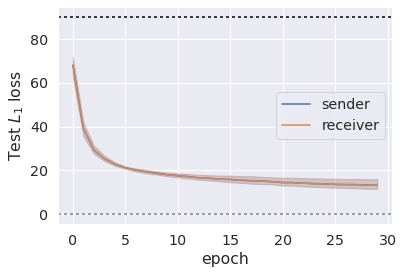

Bias 3


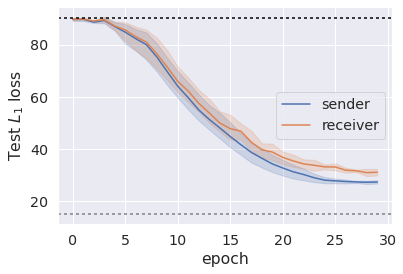

Bias 6


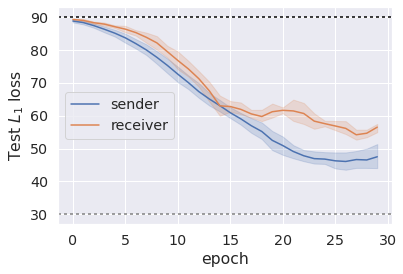

Bias 9


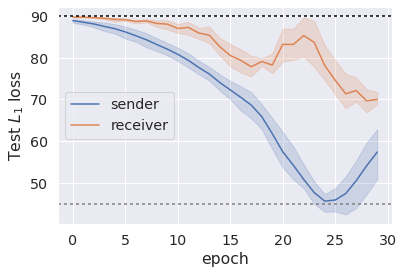

Bias 12


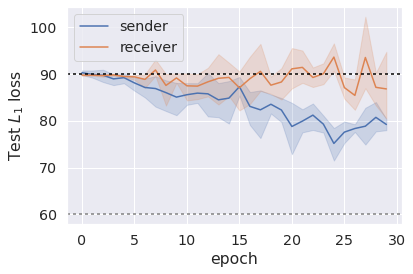

Bias 15


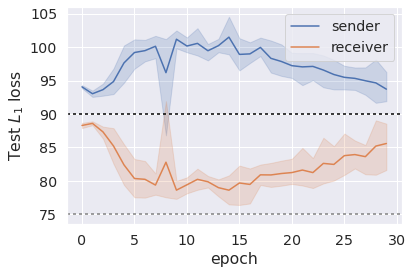

Bias 18


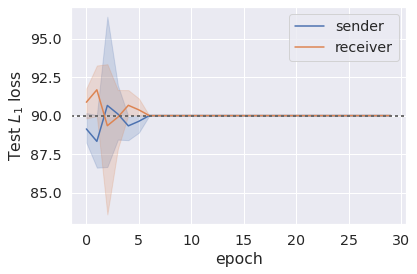

All Biases


No handles with labels found to put in legend.


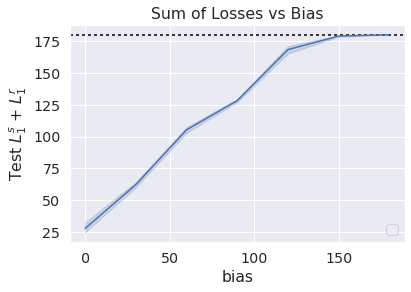

<Figure size 432x288 with 0 Axes>

In [52]:
# Discrete Messages


resultspath = result_dir / 'cat-deter'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Sum of Losses vs Bias', skip_18=False)

    

Bias 0
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15
All Biases
Bias 0
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15
All Biases


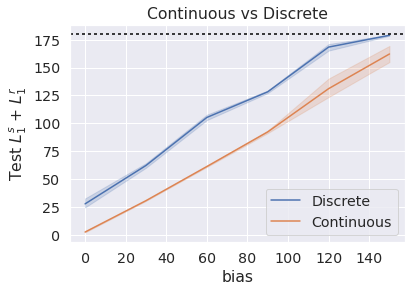

In [51]:
## Continuous v Discrete 

discrete_path = result_dir / 'cat-deter'
cont_path = result_dir / 'gauss-deter-dim1'

with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    
    label='Discrete'
    plot_hyperparam_results(discrete_path, label, discrete_path / 'plots', show=False)
    
    label='Continuous'
    plot_hyperparam_results(cont_path, label, cont_path / 'plots', show=False)

    plt.axhline(torch.tensor(360 / 2), color="black", dashes=(2,2,2,2))
    
    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.title('Continuous vs Discrete')
    plt.savefig(f'../results/discrete-v-continuous.png',  bbox_inches='tight')

Bias 0


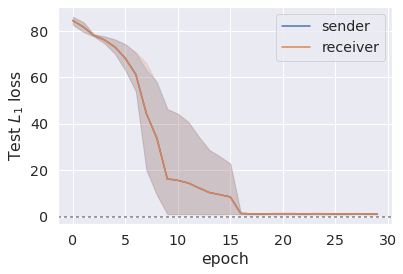

Bias 3


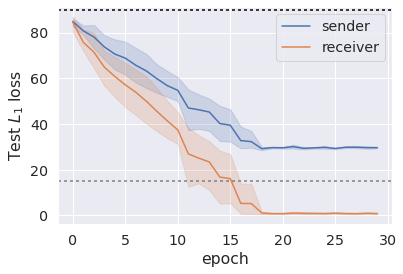

Bias 6


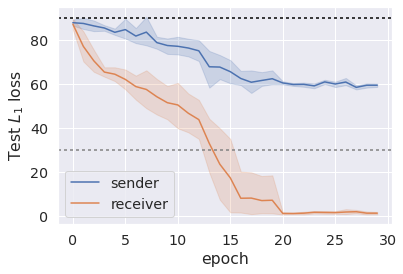

Bias 9


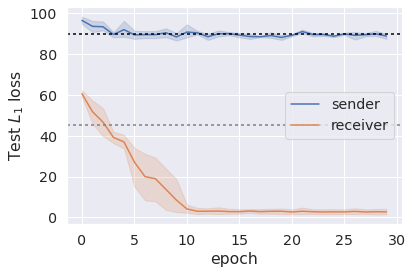

Bias 12


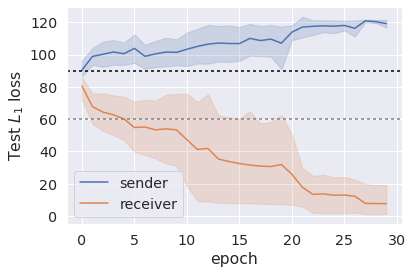

Bias 15


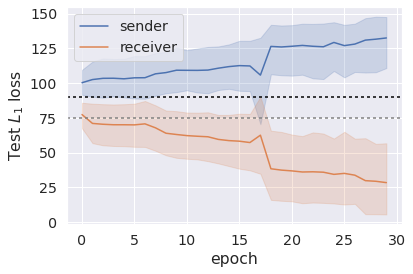

All Biases


No handles with labels found to put in legend.


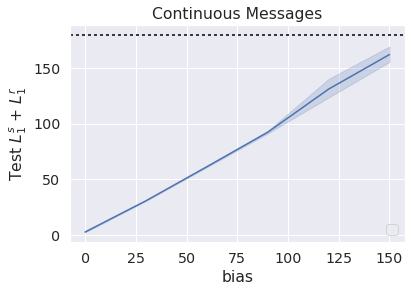

<Figure size 432x288 with 0 Axes>

In [39]:
## Continuous

resultspath = result_dir / 'gauss-deter-dim1'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Continuous Messages')

Bias 0


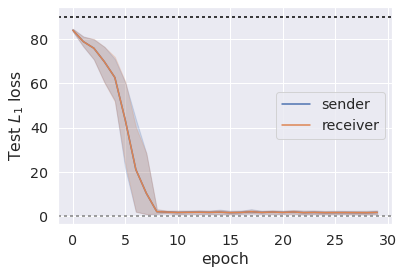

Bias 3


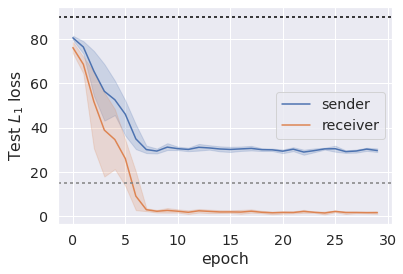

Bias 6


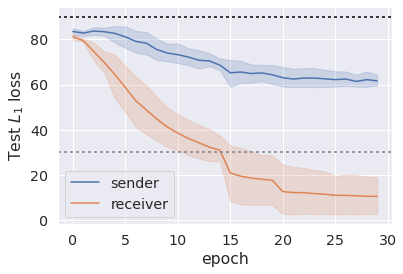

Bias 9


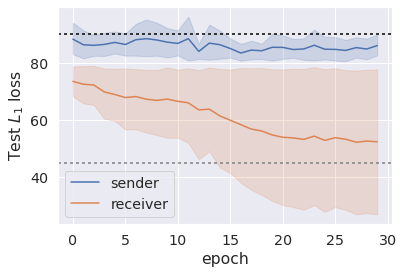

Bias 12


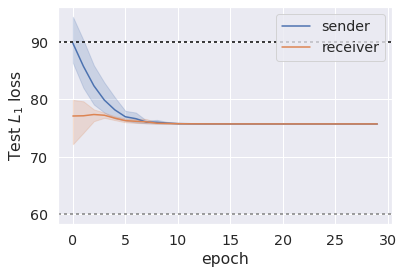

Bias 15


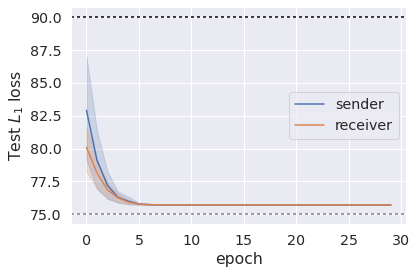

All Biases


No handles with labels found to put in legend.


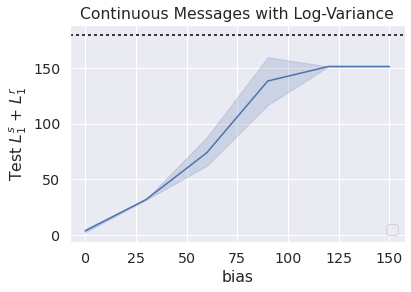

<Figure size 432x288 with 0 Axes>

In [44]:
## VarGauss

resultspath = result_dir / 'vargauss-deter'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Continuous Messages with Log-Variance')